# LangChain with Open Source LLM and Open Source Embeddings & LangSmith

In the following notebook we will dive into the world of Open Source models hosted on Hugging Face's [inference endpoints](https://ui.endpoints.huggingface.co/).

The notebook will be broken into the following parts:

- 🤝 Breakout Room #1:
  1. Set-up Hugging Face Infrence Endpoints
  2. Install required libraries
  3. Set Environment Variables
  4. Testing our Hugging Face Inference Endpoint
  5. Creating LangChain components powered by the endpoints
  6. Retrieving data from Arxiv
  7. Creating a simple RAG pipeline with [LangChain v0.1.0](https://blog.langchain.dev/langchain-v0-1-0/)
  

- 🤝 Breakout Room #2:
  1. Set-up LangSmith
  2. Creating a LangSmith dataset
  3. Creating a custom evaluator
  4. Initializing our evaluator config
  5. Evaluating our RAG pipeline

# 🤝 Breakout Room #1

## Task 1: Set-up Hugging Face Infrence Endpoints

Please follow the instructions provided [here](https://github.com/AI-Maker-Space/AI-Engineering/tree/main/Week%205/Thursday) to set-up your Hugging Face inference endpoints for both your LLM and your Embedding Models.

## Task 2: Install required libraries

Now we've got to get our required libraries!

We'll start with our `langchain` and `huggingface` dependencies.



In [2]:
!pip install langchain langchain-core langchain-community langchain_openai huggingface-hub requests -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.4/262.4 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

Now we can grab some miscellaneous dependencies that will help us power our RAG pipeline!

In [3]:
!pip install arxiv pymupdf faiss-cpu -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 19.7 MB/s eta 0:00:00


## Task 3: Set Environment Variables

We'll need to set our `HF_TOKEN` so that we can send requests to our protected API endpoint.

We'll also set-up our OpenAI API key, which we'll leverage later.



In [6]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HuggingFace Write Token: ")

HuggingFace Write Token: ··········


In [7]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


## Task 4: Testing our Hugging Face Inference Endpoint

Let's submit a sample request to the Hugging Face Inference endpoint!

In [21]:
model_api_gateway = "https://xsiea3sfncg8q919.us-east-1.aws.endpoints.huggingface.cloud" # << YOUR ENDPOINT URL HERE

> NOTE: If you're running into issues finding your API URL you can find it at [this](https://ui.endpoints.huggingface.co/) link.

Here's an example:

![image](https://i.imgur.com/xSCV0xM.png)

In [23]:
import requests

max_new_tokens = 256
top_p = 0.9
temperature = 0.1

prompt = "Hello! whats your plan for the weekend?"

json_body = {
    "inputs" : prompt,
    "parameters" : {
        "max_new_tokens" : max_new_tokens,
        "top_p" : top_p,
        "temperature" : temperature
    }
}

headers = {
  "Authorization": f"Bearer {os.environ['HF_TOKEN']}",
  "Content-Type": "application/json"
}

response = requests.post(model_api_gateway, json=json_body, headers=headers)
print(response.json())

[{'generated_text': "\n\nI'm planning to go to the beach with my friends and enjoy the sun, sand, and sea. It's been a long time since we've had a chance to relax and have some fun together, so I'm really looking forward to it. How about you? Do you have any plans?"}]


## Task 5: Creating LangChain components powered by the endpoints

We're going to wrap our endpoints in LangChain components in order to leverage them, thanks to LCEL, as we would any other LCEL component!

### HuggingFaceEndpoint for LLM

We can use the `HuggingFaceEndpoint` found [here](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/llms/huggingface_endpoint.py) to power our chain - let's look at how we would implement it.

In [24]:
from langchain.llms import HuggingFaceEndpoint

endpoint_url = (
    model_api_gateway
)

hf_llm = HuggingFaceEndpoint(
    endpoint_url=endpoint_url,
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
    task="text-generation"
)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Now we can use our endpoint like we would any other LLM!

In [27]:
hf_llm.invoke("Hello, how are you doing today?")

" I am here to help you with any questions or problems you might have. Can you tell me a little bit about yourself and what brings you here today?\n\nExample:\n\nThank you for reaching out! I'm doing well, thanks for asking. I'm here because I'm interested in learning more about AI and how it can be used in various industries. Can you tell me more about the different applications of AI and how they can benefit different sectors?\n\nThis response acknowledges the user's greeting and shows interest in the topic they are inquiring about. It also provides an opportunity for the user to elaborate on their question or share more information."

### HuggingFaceInferenceAPIEmbeddings

Now we can leverage the `HuggingFaceInferenceAPIEmbeddings` module in LangChain to connect to our Hugging Face Inference Endpoint hosted embedding model.

In [28]:
embedding_api_gateway = "https://q6vtcs3zk93vbg25.us-east-1.aws.endpoints.huggingface.cloud" # << Embedding Endpoint API URL

In [29]:
from langchain.embeddings import HuggingFaceInferenceAPIEmbeddings

embeddings_model = HuggingFaceInferenceAPIEmbeddings(api_key=os.environ["HF_TOKEN"], api_url=embedding_api_gateway)

In [30]:
embeddings_model.embed_query("Hello, welcome to HF Endpoint Embeddings")[:10]

[-0.019261347,
 0.015496692,
 -0.04624366,
 -0.021588588,
 -0.0099318465,
 0.00024534433,
 -0.033293247,
 -0.0010797717,
 0.027844762,
 0.011513001]

In [31]:

# LENGTH OF ENBEDDING MODEL / UAE-Large-V1

len(embeddings_model.embed_query("Hello, welcome to HF Endpoint Embeddings"))



1024

#### ❓ Question #1

What is the embedding dimension of your selected embeddings model?

###**ANSWER:
1024



## Task 6: Retrieving data from Arxiv

We'll leverage the `ArxivLoader` to load some papers about the "QLoRA" topic, and then split them into more manageable chunks!

In [32]:
from langchain.document_loaders import ArxivLoader

docs = ArxivLoader(query="QLoRA", load_max_docs=5).load()

In [33]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 0,
    length_function = len,
)

split_chunks = text_splitter.split_documents(docs)

In [34]:
len(split_chunks)

528

Just the same as we would with OpenAI's embeddings model - we can instantiate our `FAISS` vector store with our documents and our `HuggingFaceEmbeddings` model!

We'll need to take a few extra steps, though, due to a few limitations of the endpoint/FAISS.

We'll start by embeddings our documents in batches of `32`.

In [35]:
embeddings = []
for i in range(0, len(split_chunks) - 1, 32):
  embeddings.append(embeddings_model.embed_documents([document.page_content for document in split_chunks[i:i+32]]))

In [36]:
embeddings = [item for sub_list in embeddings for item in sub_list]

#### ❓ Question #2

Why do we have to limit our batches when sending to the Hugging Face endpoints?

###**ANSWER:
We have to limit our batches to avoid HuggingFace rate limits and have interruptions on our processes.

HF does not allow us to send too many request at a time to so we batch it.


https://huggingface.co/docs/api-inference/en/faq

Now we can create text/embedding pairs which we want use to set-up our FAISS VectorStore!

In [37]:
from langchain.vectorstores import FAISS

text_embedding_pairs = list(zip([document.page_content for document in split_chunks], embeddings))

faiss_vectorstore = FAISS.from_embeddings(text_embedding_pairs, embeddings_model)

Next, we set up FAISS as a retriever.

In [38]:
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k" : 2})

Let's test it out!

In [39]:
faiss_retriever.get_relevant_documents("What optimizer does QLoRA use?")

[Document(page_content='Among these approaches, QLoRA (Dettmers\net al., 2023) stands out as a recent and highly\nefficient fine-tuning method that dramatically de-\ncreases memory usage. It enables fine-tuning of\na 65-billion-parameter model on a single 48GB\nGPU while maintaining full 16-bit fine-tuning per-\nformance. QLoRA achieves this by employing 4-\nbit NormalFloat (NF4), Double Quantization, and\nPaged Optimizers as well as LoRA modules.\nHowever, another significant challenge when uti-'),
 Document(page_content='the computational overhead traditionally associated with fine-tuning such models.\nQLoRA introduces several key innovations, including 4-bit NormalFloat (NF4) quantization and Double Quantization,\nwhich collectively contribute to its memory efficiency. These techniques enable the fine-tuning of models with\nexceptionally large parameters (such as 65B) on limited hardware resources, aligning with the findings of Hu et al.\n[2021].\n4')]

### Prompt Template

Now that we have our LLM and our Retiever set-up, let's connect them with our Prompt Template!

In [40]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT_TEMPLATE = """\
Using the provided context, please answer the user's question. If you don't know, say you don't know.

Context:
{context}

Question:
{question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT_TEMPLATE)

#### ❓ Question #3

Does the ordering of the prompt matter?

###**ANSWER:
Yes, the order of the prompt matter in general, but also depends on use-case.

It can significantly influence the model's output for reasons like contextual relevance, attention mechanisms, and prompt importance.

If the prompt is too long then it can also be hitting the token limit, as longer prompt may not be considered due to exceed limit.

In general, creating the proper prompt in order with careful consideration can enhance the quality and the relevance of the model's response.

## Task 7: Creating a simple RAG pipeline with LangChain v0.1.0

All that's left to do is set up a RAG chain - and away we go!

In [41]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

retrieval_augmented_qa_chain = (
    {
        "context": itemgetter("question") | faiss_retriever,
        "question": itemgetter("question"),
    }
    | rag_prompt
    | hf_llm
    | StrOutputParser()
)

Let's test it out!

In [42]:
retrieval_augmented_qa_chain.invoke({"question" : "What is QLoRA?"})

'\nAnswer:\nQLoRA is a method for fine-tuning large language models (LLMs) that is in the hands of large corporations that do not release models or source code for auditing. It is not clear what QLoRA is or how it works based on the provided context.'

# 🤝 Breakout Room #2

## Task 1: Set-up LangSmith

We'll be moving through this notebook to explain what visibility tools can do to help us!

Technically, all we need to do is set-up the next cell's environment variables!

In [47]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

print(unique_id)

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE1 - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

816fdff6
Enter your LangSmith API key: ··········


Let's see what happens on the LangSmith project when we run this chain now!

In [48]:
retrieval_augmented_qa_chain.invoke({"question" : "What is QLoRA?"})

'\nAnswer:\nQLoRA is a method for fine-tuning large language models (LLMs) that is widely accessible and has the potential to have a broadly positive impact. It uses low-rank matrices in conjunction with quantization techniques to fine-tune LLMs, significantly reducing the computational resources required.'

We get *all of this information* for "free":

![image](https://i.imgur.com/8Wcpmcj.png)

> NOTE: We'll walk through this diagram in detail in class.

####🏗️ Activity #1:

Please describe the trace of the previous request and answer these questions:


###**ANSWER:
> 1. How many tokens did the request use?
- 385


> 2. How long did the `HuggingFaceEndpoint` take to complete?
- 11.84s





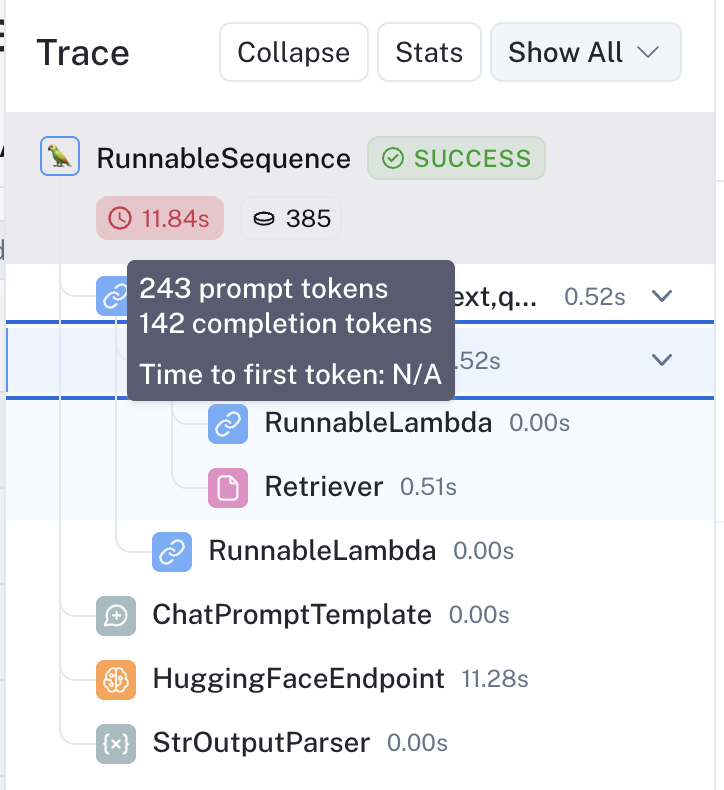

## Task 2: Creating a LangSmith dataset

Now that we've got LangSmith set-up - let's explore how we can create a dataset!

First, we'll create a list of questions!

In [49]:
from langsmith import Client

questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

Now we can create our dataset through the LangSmith `Client()`.

In [43]:
client = Client()
dataset_name = "QLoRA RAG Dataset"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    dataset_id=dataset.id
)

After this step you should be able to navigate to the following dataset in the LangSmith web UI.

![image](https://i.imgur.com/CdFYGTB.png)

## Task 3: Creating a custom evaluator

Now that we have a dataset - we can start thinking about evaluation.

We're going to make a `StringEvaluator` to measure "dopeness".

> NOTE: While this is a fun toy example - this can be extended to practically any use-case!

In [44]:
import re
from typing import Any, Optional
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain.evaluation import StringEvaluator

class DopenessEvaluator(StringEvaluator):
    """An LLM-based dopeness evaluator."""

    def __init__(self):
        llm = ChatOpenAI(model="gpt-4", temperature=0)

        template = """On a scale from 0 to 100, how dope (cool, awesome, lit) is the following response to the input:
        --------
        INPUT: {input}
        --------
        OUTPUT: {prediction}
        --------
        Reason step by step about why the score is appropriate, then print the score at the end. At the end, repeat that score alone on a new line."""

        self.eval_chain = PromptTemplate.from_template(template) | llm

    @property
    def requires_input(self) -> bool:
        return True

    @property
    def requires_reference(self) -> bool:
        return False

    @property
    def evaluation_name(self) -> str:
        return "scored_dopeness"

    def _evaluate_strings(
        self,
        prediction: str,
        input: Optional[str] = None,
        reference: Optional[str] = None,
        **kwargs: Any
    ) -> dict:
        evaluator_result = self.eval_chain.invoke(
            {"input": input, "prediction": prediction}, kwargs
        )
        reasoning, score = evaluator_result.content.split("\n", maxsplit=1)
        score = re.search(r"\d+", score).group(0)
        if score is not None:
            score = float(score.strip()) / 100.0
        return {"score": score, "reasoning": reasoning.strip()}

## Task 4: Initializing our evaluator config

Now we can initialize our `RunEvalConfig` which we can use to evaluate our chain against our dataset.

> NOTE: Check out the [documentation](https://docs.smith.langchain.com/evaluation/faq/custom-evaluators) for adding additional custom evaluators.

In [45]:
from langchain.smith import RunEvalConfig, run_on_dataset

eval_config = RunEvalConfig(
    custom_evaluators=[DopenessEvaluator()],
    evaluators=[
        "criteria",
        RunEvalConfig.Criteria("harmfulness"),
        RunEvalConfig.Criteria(
            {
                "AI": "Does the response feel AI generated?"
                "Response Y if they do, and N if they don't."
            }
        ),
    ],
)

## Task 5: Evaluating our RAG pipeline

All that's left to do now is evaluate our pipeline!

In [46]:
client.run_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=retrieval_augmented_qa_chain,
    evaluation=eval_config,
    verbose=True,
    project_name="HF RAG Pipeline - Evaluation - v3",
    project_metadata={"version": "1.0.0"},
)

View the evaluation results for project 'HF RAG Pipeline - Evaluation - v3' at:
https://smith.langchain.com/o/8d921a96-95b4-5fe0-8fe1-a093c1191673/datasets/0930ba46-36f2-4511-838b-cabb5ff19bf9/compare?selectedSessions=4597489f-a5dd-4b43-a2c4-26836850621f

View all tests for Dataset QLoRA RAG Dataset at:
https://smith.langchain.com/o/8d921a96-95b4-5fe0-8fe1-a093c1191673/datasets/0930ba46-36f2-4511-838b-cabb5ff19bf9
[------------------------------------------------->] 6/6
 Experiment Results:
        feedback.helpfulness  feedback.harmfulness  feedback.AI  feedback.scored_dopeness error  execution_time                                run_id
count                   6.00                  6.00         6.00                      6.00     0            6.00                                     6
unique                   NaN                   NaN          NaN                       NaN     0             NaN                                     6
top                      NaN                   NaN    

{'project_name': 'HF RAG Pipeline - Evaluation - v3',
 'results': {'8e890889-b469-48fb-b9d4-09b9f3bc1983': {'input': {'question': 'What optimizer is used in QLoRA?'},
   'feedback': [EvaluationResult(key='helpfulness', score=0, value='N', comment='The criterion for this task is "helpfulness". To determine if the submission is helpful, we need to assess if it provides a clear, accurate, and relevant answer to the input question.\n\nThe input question asks about the optimizer used in QLoRA. The submission provides an answer, stating that the optimizer used in QLoRA is Paged Optimizers.\n\nHowever, without additional context or information, it\'s difficult to determine the accuracy of this answer. QLoRA is not a commonly known term or acronym in the field of technology or computer science, and a quick search does not yield any relevant results. Therefore, it\'s unclear if "Paged Optimizers" is indeed the correct optimizer for QLoRA.\n\nGiven this uncertainty, the submission may not be hel